In [1]:
library(tidyverse)
library(gridExtra)
library(lubridate)

── Attaching packages ───────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ──────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
ebd_raw <- read.csv("../../app/public/data/ebird/ebd_export.csv", header = FALSE, col.names = c("date", "lat", "lon", "count"))

# convert dates from numbers to dates
ebd <- ebd_raw %>%
    mutate(
        date = as_date(date)
    )

glimpse(ebd)

Rows: 469,385
Columns: 4
$ date  <date> 1953-05-17, 1953-06-07, 1954-05-23, 1954-06-15, 1954-06-20, 19…
$ lat   <dbl> 59.01511, 59.01511, 59.01511, 59.01511, 59.01511, 59.01511, 59.…
$ lon   <dbl> 16.1053562, 16.1053562, 16.1053562, 16.1053562, 16.1053562, 16.…
$ count <int> 15, 20, 30, 4, 2, 15, 40, 5, 1, 6, 6, 10, 12, 3, 40, 20, 6, 4, …


In [22]:
library(auk)

# define paths
# f_ebd <- "../../app/public/data/ebird/ebd_barswa_1950_2020.txt"
f_ebd <- "../../app/public/data/ebird/ebd_barswa_201901_201912_relNov-2020.txt"

# read the ebd file (can take a while, don't run on full 300GB dataset)
ebd_full <- read_ebd(f_ebd)

glimpse(ebd_full)

auk 0.4.2 is designed for EBD files downloaded after 2019-08-15. 
EBD data directory:  /mnt/Windows/Users/Nimo/Documents/eBird 
eBird taxonomy version:  2019

Warning message:
“Missing column names filled in: 'X47' [47]”


### How do observations change depending on time and place on Earth?

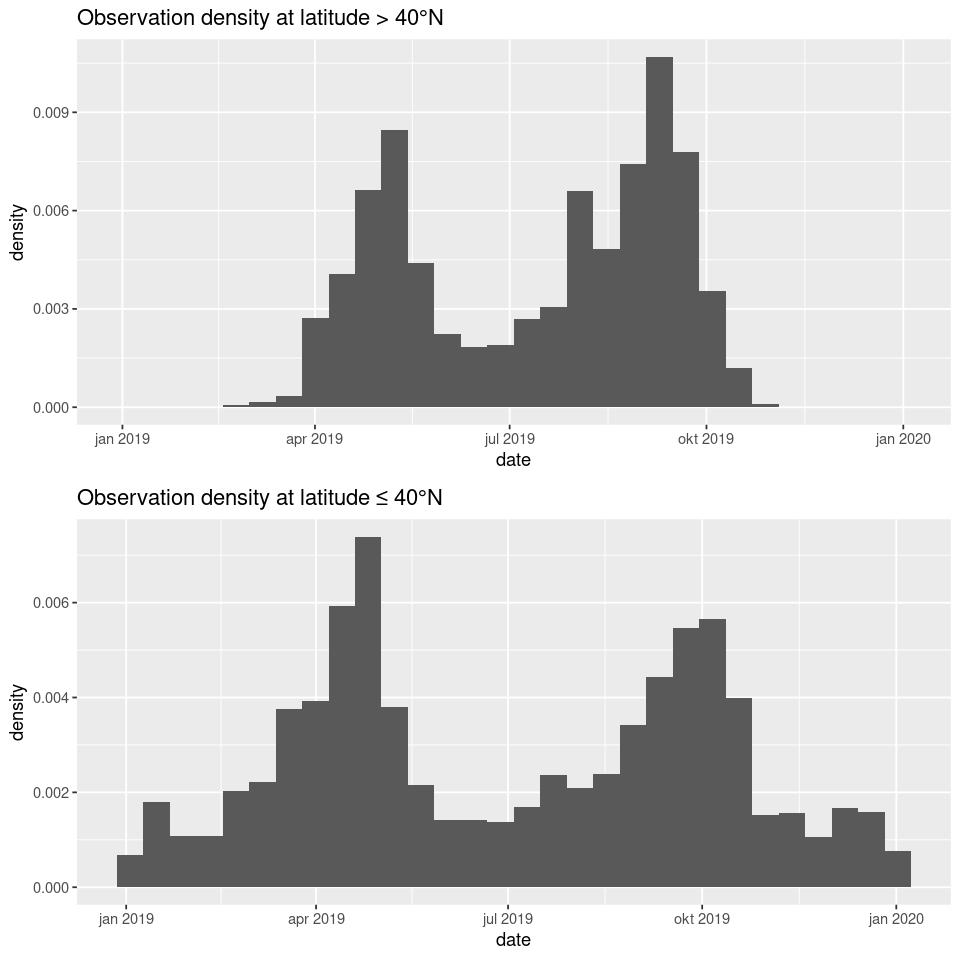

In [4]:
ebd_2019 <- ebd %>% filter(year(date) == 2019)

ebd_north <- ebd_2019 %>%
    filter(lat > 40) %>%
    group_by(date) %>%
    summarize(count_day_sum = sum(count), .groups="drop")

ebd_south <- ebd_2019 %>%
    filter(lat <= 40) %>%
    group_by(date) %>%
    summarize(count_day_sum = sum(count), .groups="drop")

plot_north <- ggplot(ebd_north) +
    geom_histogram(aes(x=date, y=..density.., weight=count_day_sum), bins=30) +
    labs(title="Observation density at latitude > 40°N")

plot_south <- ggplot(ebd_south) +
    geom_histogram(aes(x=date, y=..density.., weight=count_day_sum), bins=30) +
    labs(title="Observation density at latitude ≤ 40°N")

options(repr.plot.width=8, repr.plot.height=8)
grid.arrange(plot_north, plot_south)

### How do the observation counts change over time?

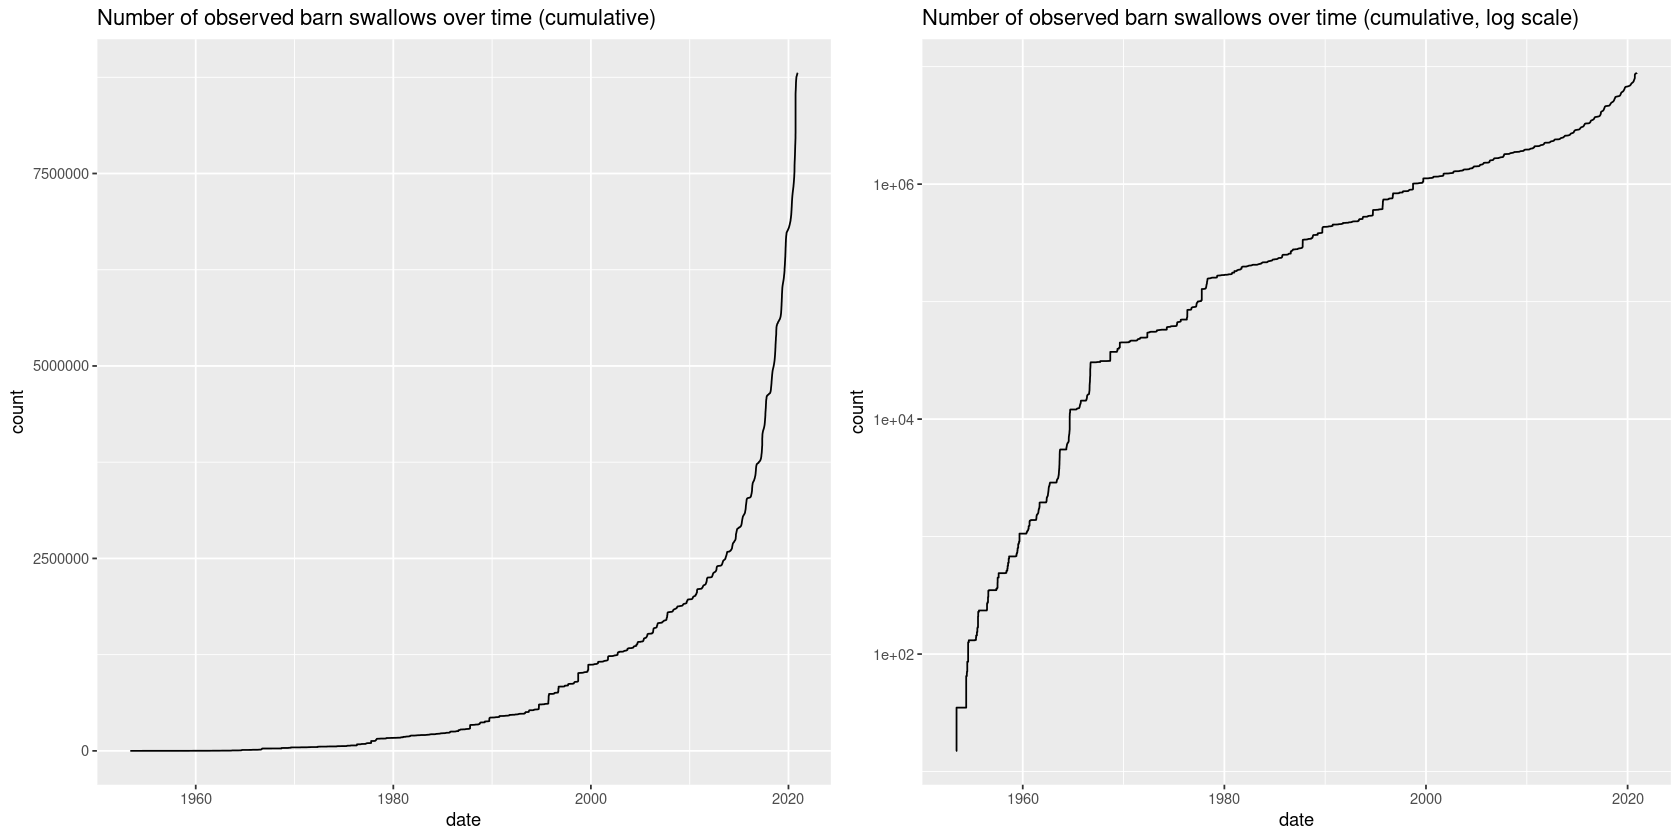

In [3]:
ebd_acc <- ebd %>%
    arrange(as.integer(date)) %>%
    mutate(
        count_acc = accumulate(count, `+`)
    )

plot_linear <- ggplot(ebd_acc) +
    geom_step(aes(x=date, y=count_acc)) +
    ylab("count") +
    labs(title="Number of observed barn swallows over time (cumulative)")

plot_log <- plot_linear + 
    scale_y_log10() +
    labs(title="Number of observed barn swallows over time (cumulative, log scale)")

options(repr.plot.width=14, repr.plot.height=7)
grid.arrange(plot_linear, plot_log, ncol=2)

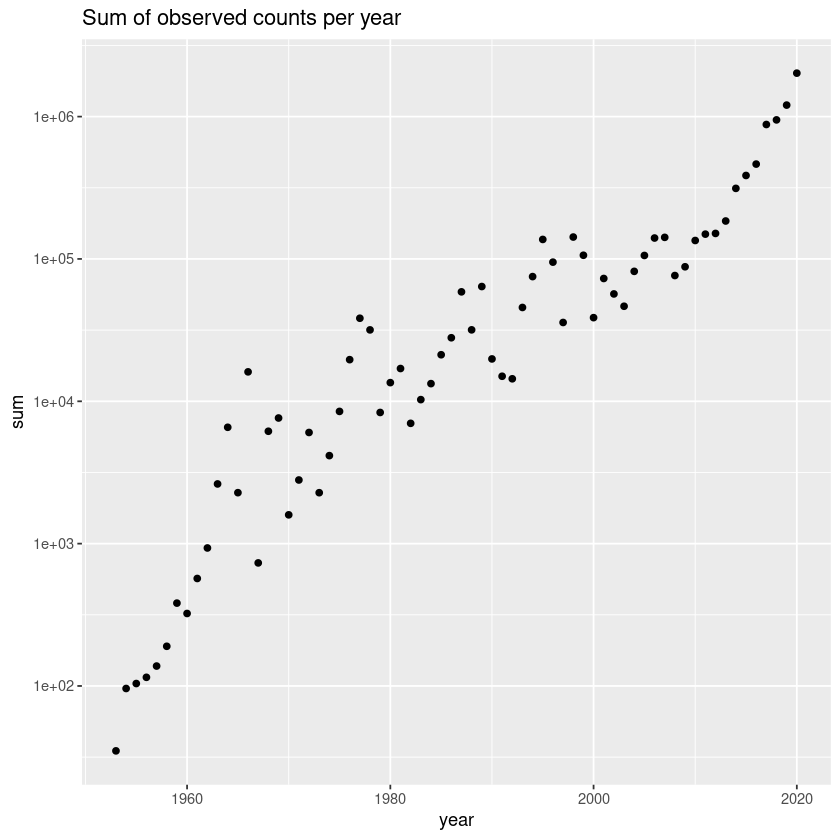

In [14]:
ebd_month_sum <- ebd %>%
    mutate(
        year = floor_date(date, unit="year")
    ) %>%
    group_by(year) %>%
    summarize(sum = sum(count), .groups="drop") %>%
    arrange(desc(sum))

ggplot(ebd_month_sum, aes(x=year, y=sum)) + 
    scale_y_log10() + 
    geom_point() +
    labs(title="Sum of observed counts per year")

### How many outliers are there?

In [10]:
ebd %>% arrange(desc(count)) %>% head(n=20)

,date,lat,lon,count
,<date>,<dbl>,<dbl>,<int>
1,2020-09-19,40.67170,0.8208510,500000
2,1998-09-19,50.91673,0.9644487,100000
3,1999-09-25,50.91673,0.9644487,50000
4,2020-09-17,40.65905,0.6948075,50000
5,1996-09-15,50.91673,0.9644487,35000
6,2017-05-06,51.40556,3.5284057,34925
7,2001-09-25,43.37361,28.4645462,30000
8,1977-10-04,40.19353,27.9617491,25000
9,1996-09-25,50.91673,0.9644487,25000


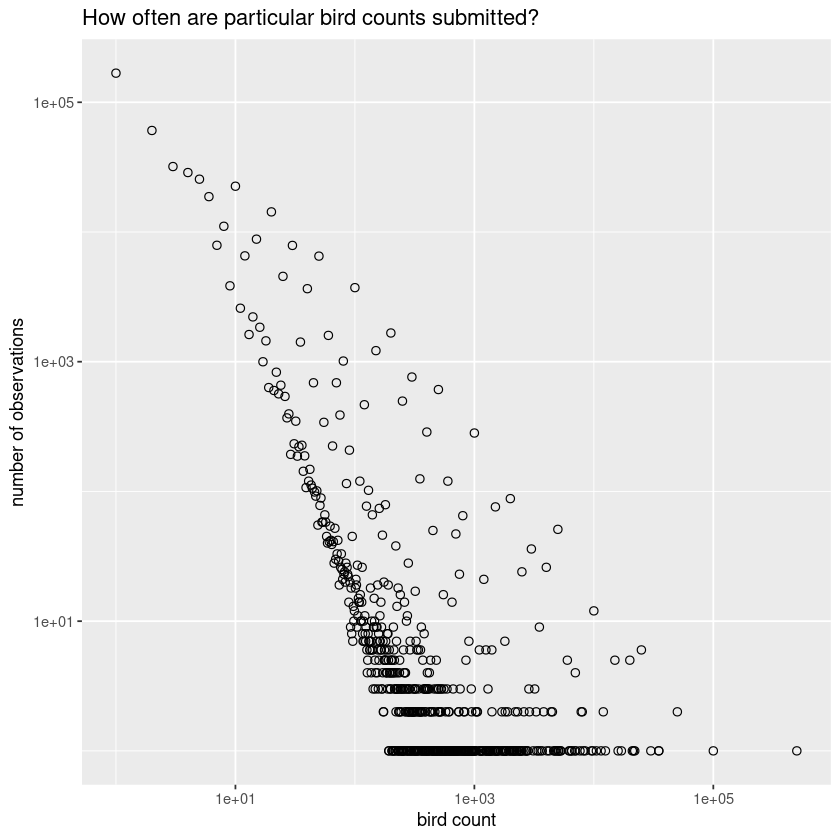

In [11]:
count_summary <- ebd %>%
    transmute(bird_count = count) %>% 
    group_by(bird_count) %>%
    summarize(observation_count = n(), .groups="drop")

ggplot(count_summary, aes(x=bird_count, y=observation_count)) + 
    geom_point(shape=1, size=2) +
    scale_x_log10() +
    scale_y_log10() +
    labs(title="How often are particular bird counts submitted?", x="bird count", y="number of observations")

In [3]:
outliers <- ebd %>% filter(count >= 1000) %>% arrange(desc(count))

nrow(outliers)
nrow(ebd)

sum(outliers$count)
sum(ebd$count)

ebd_no_out <- ebd %>% filter(count < 1000)

[1] 837

[1] 469385

[1] 3058269

[1] 8803685

### Generating a grid

In [68]:
ebd_grid <- ebd_no_out %>%
    transmute(
        date = floor_date(date, unit="month"),
        lat = floor(lat),
        lon = floor(lon),
        count = count
    ) %>%
    # sum counts for all rows with the same month, lat and lon
    group_by(date, lat, lon) %>%
    summarize(cell_count = sum(count), .groups="drop")

glimpse(ebd_grid)

Rows: 57,330
Columns: 4
$ date       <date> 1953-05-01, 1953-06-01, 1954-05-01, 1954-06-01, 1954-07-0…
$ lat        <dbl> 59, 59, 59, 59, 59, 58, 59, 45, 58, 58, 57, 58, 58, 51, 58…
$ lon        <dbl> 16, 16, 16, 16, 16, 16, 16, 12, 16, 16, -5, 16, 16, 0, 16,…
$ cell_count <int> 15, 20, 30, 6, 15, 5, 40, 1, 12, 10, 3, 52, 26, 4, 30, 37,…


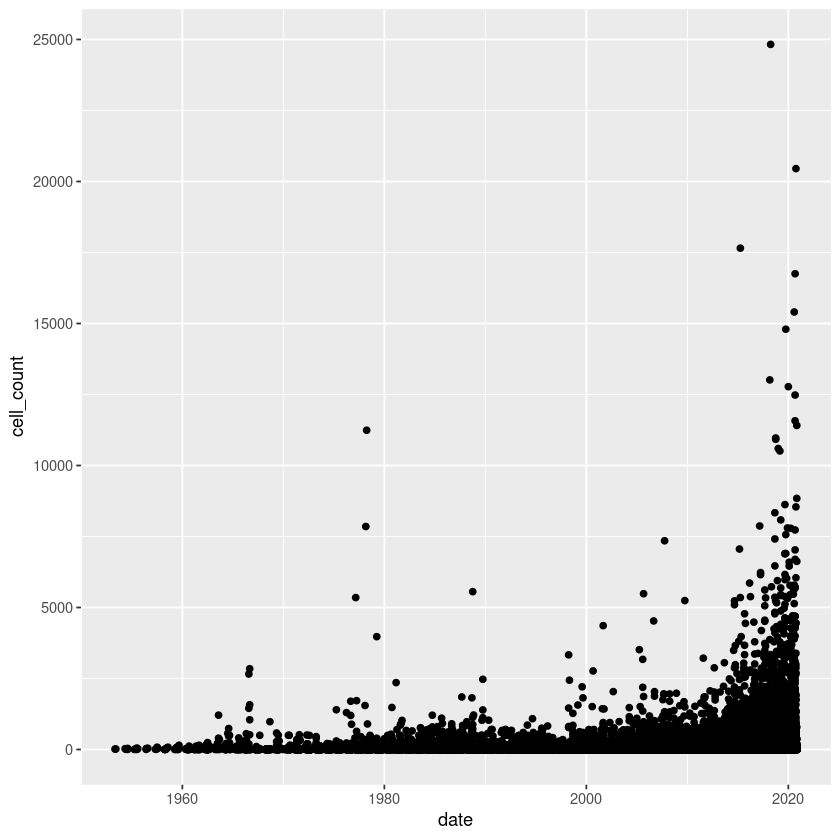

In [70]:
ggplot(ebd_grid, aes(x=date, y=cell_count)) + geom_point()

In [69]:
# get the total count for each month
month_summary <- ebd_no_out %>%
    transmute(
        date = floor_date(date, unit="month"),
        count = count
    ) %>%
    group_by(date) %>%
    summarize(month_count = sum(count), .groups="drop") %>%
    arrange(date)

glimpse(month_summary)

Rows: 697
Columns: 2
$ date        <date> 1953-05-01, 1953-06-01, 1954-05-01, 1954-06-01, 1954-07-…
$ month_count <int> 15, 20, 30, 6, 15, 45, 1, 12, 10, 55, 26, 34, 37, 44, 10,…


In [72]:
ebd_grid_intensities <- ebd_grid %>% 
    inner_join(month_summary, by="date") %>% 
    mutate(
        # compute cell count relative to total month count
        intensity = cell_count / month_count
    ) %>%
    # scale intensity to [0,1] for each month
    group_by(date) %>%
    mutate(intensity = intensity / max(intensity)) %>%
    ungroup()

head(ebd_grid_intensities, n=20)

date,lat,lon,cell_count,month_count,intensity
<date>,<dbl>,<dbl>,<int>,<int>,<dbl>
1953-05-01,59,16,15,15,1.00000000
1953-06-01,59,16,20,20,1.00000000
1954-05-01,59,16,30,30,1.00000000
1954-06-01,59,16,6,6,1.00000000
1954-07-01,59,16,15,15,1.00000000
1954-08-01,58,16,5,45,0.12500000
1954-08-01,59,16,40,45,1.00000000
1955-04-01,45,12,1,1,1.00000000
1955-05-01,58,16,12,12,1.00000000


### Generate JSON from grid

In [145]:
library(jsonlite)

f_output <- "../../app/public/data/ebird/ebd_grid.json"

all_list <- list()

years <- ebd$date %>% year %>% unique
months <- 1:12
for (y in years) {
    year_list <- list()
    for (m in months) {
        month_list <- list()
        month_df <- ebd_grid_intensities %>%
            filter(year(date) == y & month(date) == m) %>%
            select(lat, lon, intensity)
        
        if (nrow(month_df) > 0) {
            # convert dataframe to list of (equal-length) vectors
            month_list <- split(month_df, seq(nrow(month_df))) %>% lapply(unlist)
            names(month_list) <- NULL
        }
        
        year_list[[m]] <- month_list
    }
    
    # use the year as the key to create a JSON object
    # lists without names form a JSON array
    all_list[[paste(y)]] <- year_list
}

all_list %>% toJSON %>% write(file=f_output)

### Generating a grid from original EBD (incomplete)

In [39]:
# define export file path
f_export <- "../../app/public/data/ebird/ebd_grid.csv"

ebd_grid_full <- ebd_full %>%
    transmute(
        date = floor_date(observation_date, unit="month"),
        lat_round = floor(latitude),
        lon_round = floor(longitude),
        # set unknown observation counts to 1
        count = as.integer(
            if_else(
                observation_count == "X" | is.na(observation_count),
                "1",
                observation_count
            )
        )
    ) %>%
    # filter out observations outside europe/africa
    filter(-30 < lon_round & lon_round < 60) %>%
    # sum counts for all rows with the same month, lat and lon
    group_by(date, lat_round, lon_round) %>%
    summarize(sum_count = sum(count), .groups="drop") %>%
    # sort by ascending date
    arrange(date, lat_round, lon_round) %>%
    # format date the way we like it
    mutate(date = format(date, '%Y-%m'))

# print info before exporting
glimpse(ebd_grid_full)

# write to file
write.table(ebd_grid_full, f_export, sep = ",", quote = FALSE, row.names = FALSE, col.names = FALSE)

Rows: 7,441
Columns: 4
$ date      <chr> "2019-01", "2019-01", "2019-01", "2019-01", "2019-01", "201…
$ lat_round <dbl> -35, -35, -35, -35, -35, -35, -35, -34, -34, -34, -34, -34,…
$ lon_round <dbl> 18, 19, 20, 21, 22, 23, 24, 18, 19, 20, 22, 23, 24, 25, 26,…
$ sum_count <int> 8804, 7, 853, 305, 10, 110, 150, 176, 47, 18, 35, 155, 33, …
